# Problem Set

1. **(10 pts)**  
   Create a scan (series of data) consisting entirely of 4096 uncorrelated Gaussian samples with mean \( z = 0 \) and variance \( \sigma = 1 \).  
   Graph the data as a function of the sample number.

2. **(20 pts)**  
   The power spectrum formula is standard:  
   $$
   f(t) = \int_{-\infty}^{\infty} F(\omega)e^{-i\omega t} d\omega
   $$
   where \( F(\omega) \) are phased amplitudes of the transform. The power spectrum is \( \| F(\omega) \|^2 \).  

   Take your favorite implementation of the FFT, and form the power spectrum of the scan. Graph the spectrum.

3. **(40 pts)**  
   Due to Parseval’s theorem relating the variance of \( f \) and the variance in the mean of the power spectrum, for a DFT, relevant to this problem, an estimate of the variance of \( f \) is the integral of the (discrete) power spectrum:  
   $$
   \sigma^2 = \sum_i \| \hat{F}_{\omega_i} \|^2.
   $$  
   The variance in the estimated mean of \( f \) is:  
   $$
   \text{Var}[\hat{\mu}] = \| \hat{F}_0 \|^2.
   $$  

   The value at zero frequency is not known but can be extrapolated from the available power spectrum. Integrate numerically the power spectrum: is the answer the variance of the input data? If not, why not?

4. **(30 pts)**  
   Now convolve the data with your favorite normalized filter. From the zero frequency of the power spectrum, what is the variance in the mean?  

   Does it change if you change the width of the filter? Discuss your findings.


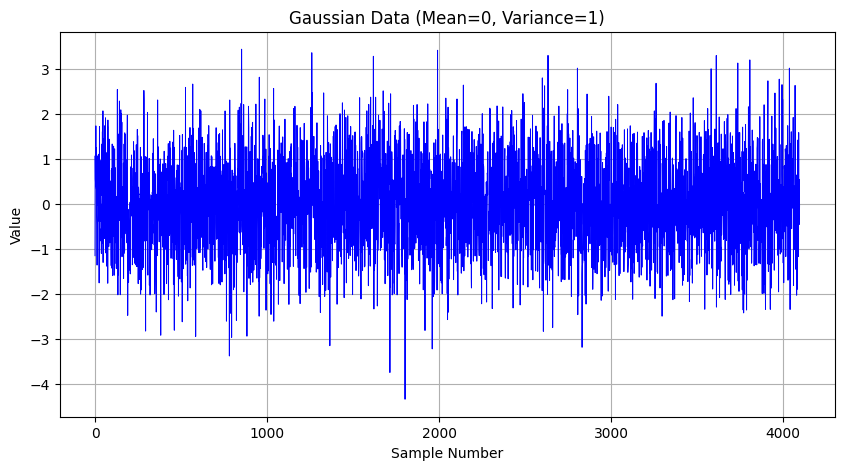

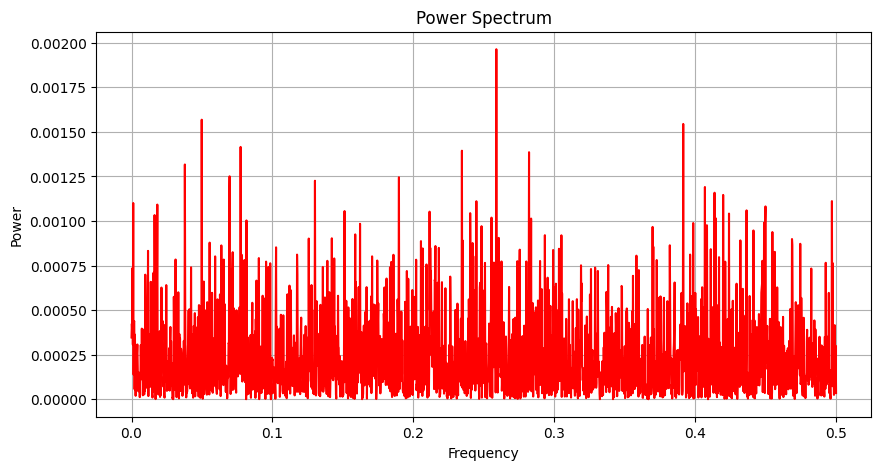

Variance in Time Domain (direct computation): 0.9952124361737728
Variance from Power Spectrum (Parseval's theorem): 0.9955591348215955
Power at Zero Frequency (DC component): 0.00034669864782262795


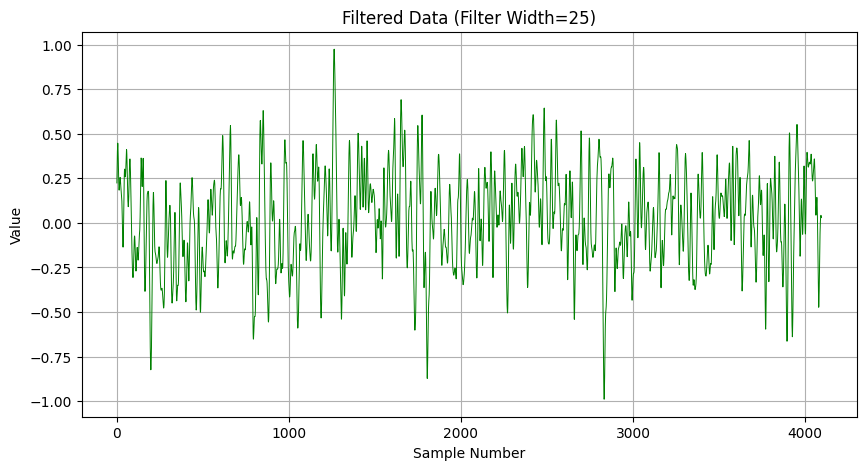

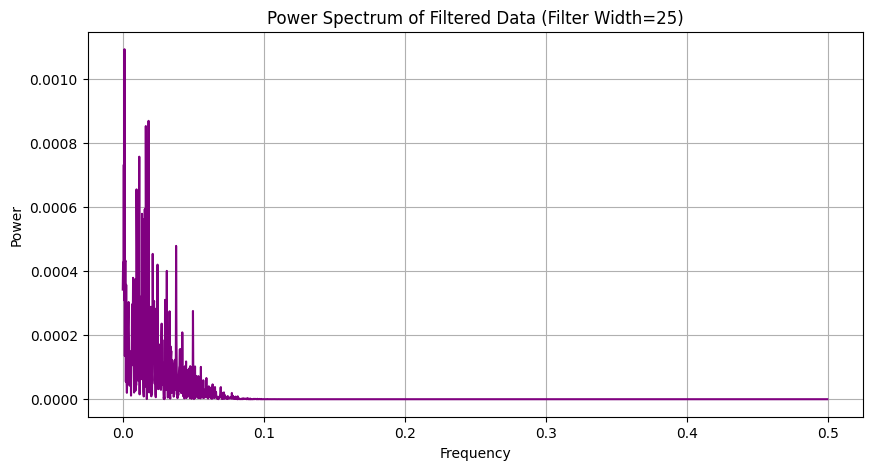

Power at Zero Frequency (Before Filtering): 0.00034669864782262795
Power at Zero Frequency (After Filtering): 0.00034259742005494806


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Generate Gaussian Data
num_samples = 4096  # samples
mean = 0            # Mean of the Gaussian distribution
std_dev = 1         

# Generate Gaussian random samples
data = np.random.normal(mean, std_dev, num_samples)

# Plot the data as a function of sample number
plt.figure(figsize=(10, 5))
plt.plot(data, color='blue', linewidth=0.7)
plt.title("Gaussian Data (Mean=0, Variance=1)")
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.grid()
plt.show()


# Compute the Fourier Transform of the data
fft_result = np.fft.fft(data)

# Compute the power spectrum 
power_spectrum = (np.abs(fft_result)**2) / (num_samples**2)

# Compute the corresponding frequencies
frequencies = np.fft.fftfreq(num_samples)

# Plot the power spectrum (only positive frequencies)
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:num_samples // 2], power_spectrum[:num_samples // 2], color='red')
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid()
plt.show()

# Part 3: Apply Parseval's Theorem 
# Compute the sigma in time domain directly from the data
variance_time_domain = np.var(data)

# Correct the power spectrum normalization for Parseval's theorem
variance_frequency_domain = np.sum(power_spectrum)

# Extract the zero-frequency component (DC component)
zero_frequency_power = power_spectrum[0]

# Print results
print("Variance in Time Domain (direct computation):", variance_time_domain)
print("Variance from Power Spectrum (Parseval's theorem):", variance_frequency_domain)
print("Power at Zero Frequency (DC component):", zero_frequency_power)

# Part 4: 
# Define a normalized Gaussian filter
filter_width = 25 
gaussian_filter = np.exp(-np.linspace(-2, 2, filter_width)**2)
gaussian_filter /= np.sum(gaussian_filter) 

# Convolve the data with the Gaussian filter
filtered_data = np.convolve(data, gaussian_filter, mode='same')

# Plot the filtered data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data, color='green', linewidth=0.7)
plt.title(f"Filtered Data (Filter Width={filter_width})")
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.grid()
plt.show()

# Compute the power spectrum of the filtered data
fft_filtered = np.fft.fft(filtered_data)
power_spectrum_filtered = (np.abs(fft_filtered)**2) / (num_samples**2)

# Compute the zero-frequency power after filtering
zero_frequency_power_filtered = power_spectrum_filtered[0]

# Plot the power spectrum of the filtered data
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:num_samples // 2], power_spectrum_filtered[:num_samples // 2], color='purple')
plt.title(f"Power Spectrum of Filtered Data (Filter Width={filter_width})")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid()
plt.show()

# Print the zero-frequency power before and after filtering
print("Power at Zero Frequency (Before Filtering):", zero_frequency_power)
print("Power at Zero Frequency (After Filtering):", zero_frequency_power_filtered)



Variance in Time Domain (direct computation): 0.9952124361737728. 
This is the directly computed variance from the time-domain data.

Variance from Power Spectrum (Parseval's theorem): 0.9955591348215955
This is the variance calculated by summing the power spectrum (frequency domain) with proper scaling. 
The slight difference is due to numerical precision and floating-point operations.



Power at Zero Frequency (DC Component):0.00035

0.00035: This represents the energy associated with the mean of the signal. For a Gaussian distribution with a mean close to zero, this value is very small, as expected